我们来挑战一个在现实世界中非常有价值且具有一定复杂性的问题：预测个人贷款是否会违约。

这是一个典型的二分类问题，在金融风控领域至关重要。银行或金融机构需要根据客户的个人信息和信用历史，来判断是否批准其贷款申请，以及应该设定什么样的利率。

一、 复杂问题：个人贷款违约预测
问题描述：
银行拥有大量历史贷款客户的数据。对于每个客户，都记录了一系列特征，如：
个人信息：年龄、收入、工作年限、住房情况（自有/租赁）、婚姻状况等。
贷款信息：贷款金额、贷款期限、贷款利率、贷款用途（购车/教育/创业）等。
信用历史：历史逾期次数、信用卡使用情况、现有债务等。
目标：
建立一个预测模型，当一个新的贷款申请进来时，模型能够根据申请人的这些特征，准确地预测出该笔贷款未来 **“会违约” (Default)** 还是 **“不会违约” (Not Default)** 。

为什么这个问题很复杂？

特征多样且关系复杂：影响违约的因素众多，既有数值型特征（如收入），也有类别型特征（如住房情况）。这些特征之间的关系往往是非线性的。例如，收入和贷款金额单独看可能无法决定是否违约，但它们的比率（即“贷收比”）可能是一个极其重要的指标。
数据不平衡 (Imbalanced Data)：在现实中，绝大多数贷款都是正常还款的，真正违约的客户只占一小部分。这会导致模型很容易“躺平”，即把所有新申请都预测为“不会违约”，也能获得很高的表面准确率，但这对于银行风控来说是毫无价值的。
高维特征：真实的银行数据集可能有上百甚至上千个特征，包括各种复杂的衍生变量。
对精度的苛刻要求：
漏报 (False Negative)：把一个未来的违约客户预测为“不会违约”，并发放贷款，这会给银行带来直接的经济损失。
误报 (False Positive)：把一个本可以正常还款的优质客户预测为“会违约”，并拒绝贷款，这会损失一个潜在的盈利机会。
模型需要在两者之间找到一个最佳的平衡点。
随机森林非常适合解决这类问题，因为它能自动处理非线性关系、高维特征，并且对数据中的噪声不敏感。

--- 数据集预览 ---
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.316239  -0.738559   1.874694   5.872222   0.695666   1.175949   
1  -1.734204   2.252186  -0.001146   6.611193   2.069585  -0.167940   
2  -0.537714   2.284180  -0.280541  -1.254194   0.606642   0.540619   
3  -4.405916  -0.466085  -0.272065   1.886191   0.870682  -0.056514   
4   0.149768  -3.300590   0.309379  -1.133932   2.532256   0.453839   

   feature_6  feature_7  feature_8  feature_9  ...  feature_11  feature_12  \
0  -0.329178  -2.464584  -1.180278   2.492204  ...    0.517580   -1.541858   
1   0.947503   1.825009   2.004587  -5.623679  ...   -0.271407   -1.151960   
2   0.766000   4.525325   1.057896  -5.592385  ...   -2.120353    0.131399   
3   0.399740  -2.762257  -3.338165  -0.994501  ...   -0.742960   -0.879030   
4   0.028972  -5.872717   0.593947   1.810935  ...   -0.022571   -0.305504   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  \
0   -0.005058

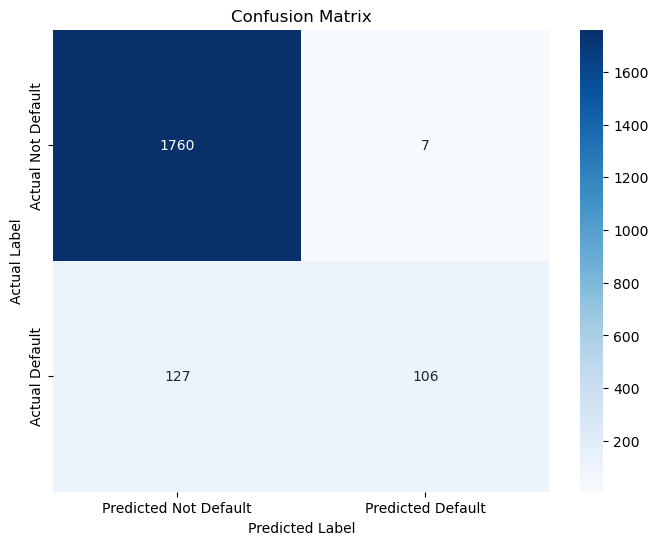

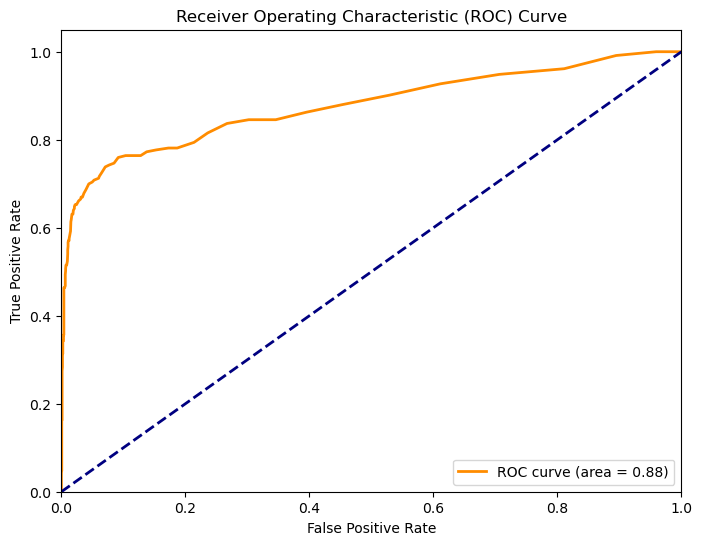

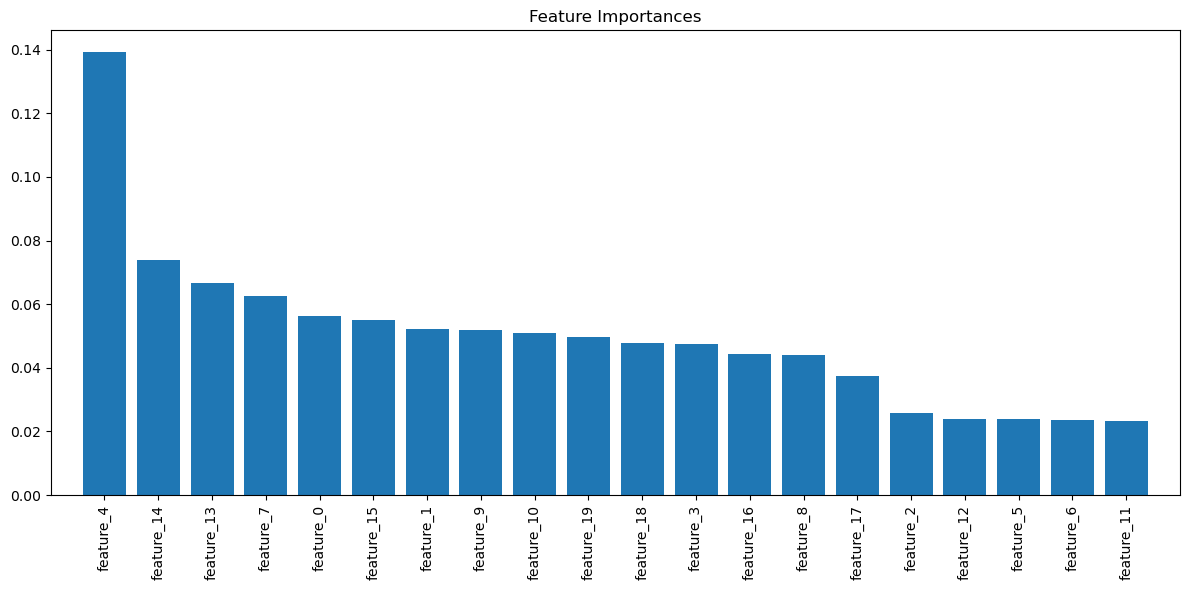


--- 不同决策阈值下的模型表现 ---

当阈值为 0.20 时:
  抓出的坏客户 (TP): 163, 漏掉的坏客户 (FN): 70
  召回率 (Recall): 69.96%
  精确率 (Precision): 67.63%

当阈值为 0.30 时:
  抓出的坏客户 (TP): 144, 漏掉的坏客户 (FN): 89
  召回率 (Recall): 61.80%
  精确率 (Precision): 83.72%

当阈值为 0.40 时:
  抓出的坏客户 (TP): 121, 漏掉的坏客户 (FN): 112
  召回率 (Recall): 51.93%
  精确率 (Precision): 88.32%

当阈值为 0.50 时:
  抓出的坏客户 (TP): 106, 漏掉的坏客户 (FN): 127
  召回率 (Recall): 45.49%
  精确率 (Precision): 93.81%


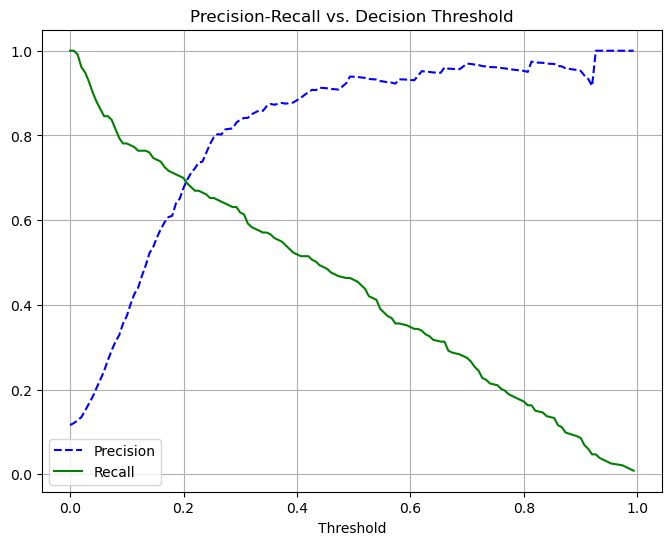

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

# --- 1. 创建一个模拟的复杂贷款数据集 ---
# make_classification可以生成一个适合分类的、有一定复杂度的合成数据集
# n_samples: 样本总数
# n_features: 总特征数
# n_informative: 有效特征数
# n_redundant: 冗余特征数
# n_classes: 类别数
# weights: 类别权重，我们创建一个不平衡数据集，90%为正常用户，10%为违约用户
X, y = make_classification(n_samples=10000,
                           n_features=20,
                           n_informative=10,
                           n_redundant=5,
                           n_classes=2,
                           weights=[0.9, 0.1],
                           flip_y=0.05,
                           random_state=42)

# 将数据转换为Pandas DataFrame以便更好地观察
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['status'] = y

print("--- 数据集预览 ---")
print(df.head())
print("\n--- 类别分布 ---")
print(df['status'].value_counts())

# --- 2. 数据预处理与划分 ---
# 将特征和目标变量分开
X = df.drop('status', axis=1)
y = df['status']

# 将数据集划分为训练集和测试集 (80% 训练, 20% 测试)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征缩放：虽然随机森林对缩放不敏感，但在很多机器学习流程中这是个好习惯
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 3. 训练随机森林模型 ---
# 创建随机森林分类器实例
# n_estimators: 森林中树的数量 (专家数量)
# class_weight='balanced': 这是一个关键参数，用于自动处理不平衡数据
# random_state: 保证结果可复现
rf_classifier = RandomForestClassifier(n_estimators=150,
                                     class_weight='balanced',
                                     random_state=42,
                                     n_jobs=-1, # 使用所有可用的CPU核心
                                     oob_score=True) # 使用袋外样本来评估模型

print("\n--- 开始训练随机森林模型 ---")
rf_classifier.fit(X_train, y_train)
print("模型训练完成!")
print(f"模型的袋外(OOB)评估准确率: {rf_classifier.oob_score_:.4f}")

# --- 4. 模型评估 ---
# 在测试集上进行预测
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1] # 预测为类别1（违约）的概率

print("\n--- 模型在测试集上的表现 ---")
# 打印准确率
print(f"准确率 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# 打印详细的分类报告 (精确率, 召回率, F1分数)
print("\n分类报告 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)']))

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Default', 'Predicted Default'],
            yticklabels=['Actual Not Default', 'Actual Default'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 绘制ROC曲线并计算AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# --- 5. 特征重要性分析 ---
# 随机森林可以告诉我们哪些特征对预测最重要
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# --- 6. 模型评估 (进阶版：调整决策阈值) ---
from sklearn.metrics import precision_recall_curve

# y_pred_proba 是模型预测为类别1（违约）的概率
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1] 

# 让我们看看不同阈值下的表现
print("\n--- 不同决策阈值下的模型表现 ---")
thresholds = [0.2, 0.3, 0.4, 0.5] # 尝试不同的阈值

for thresh in thresholds:
    # 根据新阈值生成预测结果
    y_pred_new = (y_pred_proba >= thresh).astype(int)
    
    print(f"\n当阈值为 {thresh:.2f} 时:")
    conf_matrix_new = confusion_matrix(y_test, y_pred_new)
    tn, fp, fn, tp = conf_matrix_new.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"  抓出的坏客户 (TP): {tp}, 漏掉的坏客户 (FN): {fn}")
    print(f"  召回率 (Recall): {recall:.2%}")
    print(f"  精确率 (Precision): {precision:.2%}")

# 可视化Precision-Recall曲线
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recalls[:-1], "g-", label="Recall")
plt.title("Precision-Recall vs. Decision Threshold")
plt.xlabel("Threshold")
plt.legend()
plt.grid(True)
plt.show()

分类报告 (Classification Report)：这是最重要的评估指标之一。
precision (精确率)：对于“违约(1)”类别，它表示所有被模型预测为违约的客户中，真正违约的比例。高精确率意味着模型预测的“坏客户”确实很坏，误报率低。
recall (召回率)：对于“违约(1)”类别，它表示所有真正违约的客户中，被模型成功识别出来的比例。高召回率意味着模型能有效地“抓出”坏客户，漏报率低。
f1-score：精确率和召回率的调和平均数，是一个综合指标。
关键点：由于我们设置了 class_weight='balanced'，你会发现模型在“违约(1)”这个少数类上的召回率会相当不错，这正是我们想要的——宁可错杀一千，不可放过一个坏客户。
混淆矩阵 (Confusion Matrix)：
左上角 (True Negative)：实际不违约，模型也预测不违约的数量（预测正确）。
右下角 (True Positive)：实际违约，模型也预测违约的数量（预测正确，我们最关心的）。
右上角 (False Positive)：实际不违约，但模型预测为违约的数量（误报，损失了潜在好客户）。
左下角 (False Negative)：实际违约，但模型预测为不违约的数量（漏报，给银行带来损失，是风控中最危险的错误）。
ROC曲线和AUC值：
ROC曲线下的面积 (AUC - Area Under Curve) 是衡量模型整体分类性能的金标准。
AUC值越接近1.0，说明模型区分好坏客户的能力越强。一个随机猜测的模型AUC值是0.5。通常，AUC > 0.8 就表示这是一个相当不错的模型。
特征重要性图：
这个条形图是随机森林的一大“福利”。它清晰地展示了在模型的决策过程中，哪些特征的贡献最大。
在真实的银行项目中，这个图可以帮助业务人员理解模型的决策依据，发现一些以前未曾注意到的关键风险指标。
结论：
这个例子展示了随机森林如何在一个复杂、不平衡、高维的金融风控场景中发挥其强大的威力。它不仅能给出一个高精度的预测结果，还能通过召回率等指标来满足业务对“抓坏人”的特定需求，并且提供了特征重要性这一有价值的洞察，完美地解决了这个复杂的预测问题。